# MLP Training on MNIST

In [1]:
import numpy as np
import jax
import time
import jax.numpy as jnp
from jax.scipy.special import logsumexp

from jax import random, vmap, pmap, jit
from jax.tree_util import tree_map

from torchvision.datasets import MNIST

import tensorflow as tf
import tensorflow_datasets as tfds
import functools

In [2]:
seed = 42
mnist_img_size = (28, 28)
batch_size = 128

## Initialize NN parameters

In [3]:
def init_MLP(layer_widths, key, scale=0.001):
  params = []
  keys = jax.random.split(key, num=len(layer_widths)-1)
  for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
    weight_key, bias_key = jax.random.split(key)
    params.append(
        [scale * random.normal(weight_key, shape=(in_width, out_width)),
         scale * random.normal(bias_key, shape=(out_width, ))]
    )

  return params

key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)

print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(784, 512), (512,)], [(512, 256), (256,)], [(256, 10), (10,)]]


## Forward pass for NN

In [4]:
def MLP_predict(params, inputs):
  activations = inputs
  for w, b in params[:-1]:
    outputs = jnp.dot(activations, w) + b
    activations = jax.nn.relu(outputs)

  final_w, final_b = params[-1]
  logits = jnp.dot(activations, final_w) + final_b
  return logits - logsumexp(logits)


# tests

# test single example

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

# test batched function
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(batch_size, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(784,)
(10,)
(128, 784)
(128, 10)


In [5]:
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=["train", "test"],
    shuffle_files=True,
    with_info=True,
)
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [6]:
def flatten_image(record):
  image = tf.cast(record['image'], tf.float32)  # Normalize pixel values to [0, 1]
  image = tf.reshape(image, (-1,))  # Flatten image to a 1D array
  return image, tf.one_hot(record['label'],
                           depth=ds_info.features['label'].num_classes)


num_train_images = ds_info.splits['train'].num_examples
num_test_images = ds_info.splits['test'].num_examples

train_ds = train_ds.map(flatten_image).batch(batch_size)
test_ds = test_ds.map(flatten_image).batch(batch_size)

In [7]:
def loss_fn(params, images, labels):
  preds = batched_MLP_predict(params, images)
  return -jnp.mean(preds * labels)

def accuracy(params, ds, num_examples):
  acc = 0
  for images, labels in ds.as_numpy_iterator():
    images, labels = jnp.array(images), jnp.array(labels)
    pred_labels = jnp.argmax(batched_MLP_predict(params, images), axis=1)
    labels = jnp.argmax(labels, axis=1)
    acc += np.sum(pred_labels == labels)

  return acc / num_examples

@jit
def update(params, imgs, gt_lbls, lr=0.01):
  loss, grads = jax.value_and_grad(loss_fn)(params, imgs, gt_lbls)

  return loss, jax.tree_map(lambda p, g: p - lr*g, params, grads)

num_epochs = 10
MLP_params = init_MLP([784, 512, 256, 10], key)

for epoch in range(num_epochs):
  loss_l = []
  start_time = time.time()
  for cnt, (images, labels) in enumerate(train_ds.as_numpy_iterator()):
    images, labels = jnp.array(images), jnp.array(labels)
    loss, MLP_params = update(MLP_params, images, labels)
    loss_l.append(loss)
  epoch_time = time.time() - start_time
  print(f"Epoch {epoch+1}, loss = {jnp.mean(jnp.array(loss_l))} " \
        f"train_acc = {accuracy(MLP_params, train_ds, num_train_images)} test_acc = {accuracy(MLP_params, test_ds, num_test_images)}")


Epoch 1, loss = 0.23001629114151 train_acc = 0.2772666811943054 test_acc = 0.2791999876499176
Epoch 2, loss = 0.17932893335819244 train_acc = 0.722266674041748 test_acc = 0.729200005531311
Epoch 3, loss = 0.06583252549171448 train_acc = 0.8473666906356812 test_acc = 0.8507000207901001
Epoch 4, loss = 0.046569593250751495 train_acc = 0.8805333375930786 test_acc = 0.8795999884605408
Epoch 5, loss = 0.03857836127281189 train_acc = 0.9006999731063843 test_acc = 0.8970999717712402
Epoch 6, loss = 0.03284821659326553 train_acc = 0.9146999716758728 test_acc = 0.9121000170707703
Epoch 7, loss = 0.028368880972266197 train_acc = 0.9260833263397217 test_acc = 0.9269000291824341
Epoch 8, loss = 0.0247422493994236 train_acc = 0.9353500008583069 test_acc = 0.9366999864578247
Epoch 9, loss = 0.021791478618979454 train_acc = 0.9434499740600586 test_acc = 0.9437000155448914
Epoch 10, loss = 0.019432002678513527 train_acc = 0.9492999911308289 test_acc = 0.949999988079071


(28, 28)
pred 4
gt tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


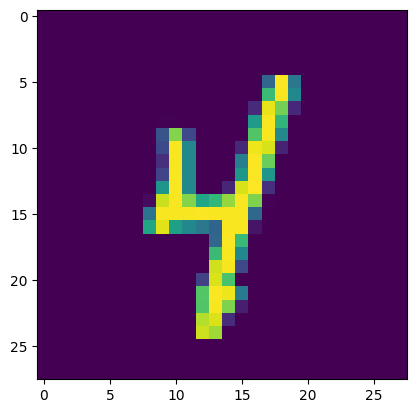

In [16]:
images, labels = next(iter(train_ds.take(1)))
img = images[0].numpy().reshape(mnist_img_size)
gt_lbl = labels[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()